### モジュールインポート

In [1]:
import csv
import requests
import bs4
import re
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from enum import Enum
import derby_func as func
import collections
from sklearn import preprocessing

### 定数宣言

RACE_CNT の値で過去何年分のレースを訓練データとするかを選択

In [2]:
RACE = "/race/"
CSV_DIR = "csv"
RACE_CNT = 21

id=xxxx に予想したいレース ID を入力 (有馬記念なら 0133)

In [3]:
PRED_RACE = 'id=0059'

In [4]:
PAGE = 'https://race.netkeiba.com/special/index.html?' + PRED_RACE
URL_RACE = "https://race.netkeiba.com/race/shutuba.html?race_id="
TRAIN_RACE_ID = func.get_train_race_id(func.get_text_from_page(PAGE), min_cnt =0, max_cnt = RACE_CNT)
PRED_RACE_ID = func.get_pred_race_id(func.get_text_from_page(PAGE))

In [5]:
RACE_NAME = func.get_name_from_text(func.get_text_from_page(URL_RACE + PRED_RACE_ID)).replace(' - netkeiba.com', '').split('(')[0]

In [6]:
TRAIN_RACE_DATA_PATH = CSV_DIR+ RACE + RACE_NAME + "/"
TRAIN_HORSE_DATA_PATH = CSV_DIR + "/horse/"
RACE_DATA_COLUMNS = func.race_data_columns()
HORSE_DATA_COLUMNS = func.horse_data_columns()
JOCKEY_DATA_COLUMNS = func.jockey_data_columns()
RACE_RANK = func.race_rank()

In [7]:
TRAIN_RACE_ID

['202205021211',
 '202105021211',
 '202005021211',
 '201905021211',
 '201805021210',
 '201705021210',
 '201605021210',
 '201505021210',
 '201405021210',
 '201305021210',
 '201205021210',
 '201105030411',
 '201005030410',
 '200905030410',
 '200805030410',
 '200705030410',
 '200605030410',
 '200505030410',
 '200405030410',
 '200305020410',
 '200205040410']

In [8]:
len(TRAIN_RACE_ID)

21

In [9]:
RACE_CNT = len(TRAIN_RACE_ID)

### DataFrame読み込み、前処理

In [10]:
df_races = []
db_horses = {}
for i in range(len(TRAIN_RACE_ID)):
    df_races.append(pd.read_csv(TRAIN_RACE_DATA_PATH + str(int(TRAIN_RACE_ID[len(TRAIN_RACE_ID) - 1][:4]) + i) + ".csv", header=None, names = RACE_DATA_COLUMNS, encoding='shift_jis'))

In [11]:
len(df_races)

21

In [12]:
def race_score_define(row):
    rank_score = 0
    for rank in RACE_RANK:
        if (rank.rank in row['race_name']):
            rank_score = rank.score
    return rank_score

In [13]:
def load_horse_data(row, num):
    load_path = TRAIN_HORSE_DATA_PATH + str(int(TRAIN_RACE_ID[len(TRAIN_RACE_ID) - 1][:4]) + int(num)) + RACE_NAME + "/" + str(row['horse_name']) + ".csv"
    path = str(int(TRAIN_RACE_ID[len(TRAIN_RACE_ID) - 1][:4]) + int(num)) + row['horse_name']
    df_tmp = pd.read_csv(load_path, header=None, names = HORSE_DATA_COLUMNS, encoding='shift_jis')
    df_tmp = df_tmp.drop(columns=['time_score', "ground_score", 'popularity', 'odds', 'R', 'winner', 'reward', "video" ,"coment", "coment_2",])
    df_tmp.dropna(how='all', axis = 1, inplace=True)
    df_tmp['ground_type'] = df_tmp.apply(lambda x: x['distance'][:1], axis = 1)
    df_tmp['distance'] = df_tmp.apply(lambda x: x['distance'][1:], axis = 1)
    df_tmp['race_rank_score'] = df_tmp.apply(race_score_define, axis = 1)
    df_tmp.dropna(how='any', axis = 0, inplace=True)
    db_horses[path] = df_tmp.reset_index()
    return path

In [14]:
def search_past_races(row, num):
    df_horse = db_horses[row['horse_data_key']]
    df_horse['race_date_judge'] = df_horse.apply(lambda x: True if str(x['race_id']) == str(TRAIN_RACE_ID[len(TRAIN_RACE_ID) - 1 - num]) else False, axis = 1)
    index = df_horse[df_horse['race_date_judge'] == True].index
    df_horse = df_horse.iloc[index[0] + 1:]
    db_horses[row['horse_data_key']] = df_horse
    if (df_horse.shape[0] > 0):
        return index[0]
    else :
        return 0

In [15]:
def rank_to_int(df):
    df_2 = df.copy()
    df_2 = df_2[(df_2['rank'] != "取") & (df_2['rank'] != "中") & (df_2['rank'] != "除") & (df_2['rank'] != "失")]
    df_2['rank'] = df_2['rank'].apply(lambda x: int(re.sub(r"\D", "", str(x))))
    return df_2

In [16]:
def calc_past_rank_ave(row):
    df_horse = db_horses[row['horse_data_key']]
    df_horse = rank_to_int(df_horse)
    df_horse['race_score'] = df_horse.apply(lambda x: 0 if x['rank'] > 5 else (x['race_rank_score'] * (4 - x['rank']) * 10) / x['head_count'], axis = 1)
    mean = df_horse['rank'].mean(axis = 0)
    db_horses[row['horse_data_key']] = df_horse
    return mean

In [17]:
def feature_creation(df_race_tmp, num = 1):
    df = df_race_tmp.copy()
    df = df[df['race_count'] > 0]
    df['past_rank_ave'] = df.apply(calc_past_rank_ave, axis = 1)
    df['before_race_rank'] = df.apply(lambda x: int(db_horses[x['horse_data_key']]['rank'][x['race_count'] + num]), axis = 1)
    df['past_rank_std'] = df.apply(lambda x: db_horses[x['horse_data_key']]['rank'].std(axis = 0), axis = 1)
    df['med_race_score'] = df.apply(lambda x: db_horses[x['horse_data_key']]['race_score'].median(axis = 0), axis = 1)
    return df.fillna(0)

In [22]:
def add_jockey_info(row):
    _id = str(str(row['jockey_id']).zfill(5))
    load_path = "csv/jockey/" + _id + ".csv"
    df_joc = pd.read_csv(load_path, header=None, names = JOCKEY_DATA_COLUMNS, encoding='shift_jis')
    return float(df_joc[df_joc["year"] == str(int(row['horse_data_key'][:4]))]["3-2-1_rate"])

In [24]:
df_races_2 = df_races.copy()
drop_columns = ['trainer', 'owner', 'jockey', 'reward', 'difference', 'lap_time', 'final_3F', 'time', 'time_score']
for i in range(len(TRAIN_RACE_ID)):
    df_races_2[i].fillna({'time_score': '**'})
    df_races_2[i].dropna(how='all', axis = 1, inplace=True)
    df_races_2[i] = rank_to_int(df_races_2[i])
    df_races_2[i] = df_races_2[i].drop(columns = drop_columns, errors = 'ignore')
    df_races_2[i]['horse_data_key'] = df_races_2[i].apply(load_horse_data, num = i, axis = 1)
    df_races_2[i]['race_count'] = df_races_2[i].apply(search_past_races, num = i, axis = 1)
    df_races_2[i]['jockey_rate'] = df_races_2[i].apply(add_jockey_info, axis = 1)
    df_races_2[i] = feature_creation(df_races_2[i])
df_races_2[0].head(5)

,rank,frame_number,horse_number,horse_name,aptitude_course,aptitude_distance,aptitude_run,aptitude_growth,aptitude_ground,age,...,odds,popularity,horse_weight,horse_data_key,race_count,jockey_rate,past_rank_ave,before_race_rank,past_rank_std,med_race_score
1,2,6,11,シンボリクリスエス,107,45,29,44,60,牡3,...,6.2,3,520(-6),2002シンボリクリスエス,8,0.398,1.833333,1,0.983192,15.476190
2,3,4,8,マチカネアカツキ,108,60,100,72,64,牡3,...,16.7,6,512(-4),2002マチカネアカツキ,4,0.526,1.750000,2,0.462910,59.027778
3,4,5,10,メガスターダム,111,41,94,52,61,牡3,...,27.5,9,490(-2),2002メガスターダム,8,0.269,3.583333,1,2.466441,3.125000
4,5,8,18,ゴールドアリュール,22,56,109,55,85,牡3,...,48.1,13,498(-4),2002ゴールドアリュール,6,0.220,2.625000,1,1.597990,7.417582
5,6,3,5,アドマイヤドン,35,58,62,54,87,牡3,...,25.1,8,440(-10),2002アドマイヤドン,15,0.360,2.600000,7,2.607681,36.363636


### レースの特徴表示

In [25]:
df_all_races = pd.concat(df_races_2)
len(df_all_races)

352

In [26]:
df_all_races_rank = []
df_all_races_rank.append(df_all_races[df_all_races['rank'] == 1])
df_all_races_rank.append(df_all_races[df_all_races['rank'] <= 3])
df_all_races_rank.append(df_all_races)

In [27]:
def plot_count_columns(column_name, _bins = 20, _range = (0, 20)):
    titles = ["Rank1", "InTicket", "All"]
    fig = plt.figure(figsize=(10, 10))
    for i in range(len(df_all_races_rank)):
        plt.subplot(len(df_all_races_rank), 3, i+1)
        plt.title(titles[i] + "_" + column_name)
        plt.hist(df_all_races_rank[i][column_name], bins=_bins, range = _range)
        plt.tight_layout()
        print(titles[i] + "：サンプル数" + str(len(df_all_races_rank[i])))
    plt.style.use('default')
    plt.savefig(f"images/{column_name}.png", bbox_inches='tight')

過去20年で1着及び馬券内だった馬の枠番

Rank1：サンプル数18
InTicket：サンプル数57
All：サンプル数352


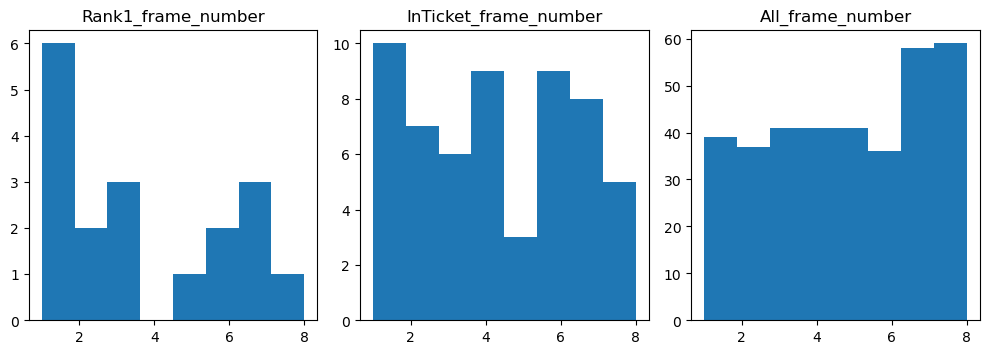

In [28]:
plot_count_columns('frame_number', 8, (1, 8))

過去20年で1着及び馬券内だった馬の距離適性(高いほど短距離得意)

Rank1：サンプル数18
InTicket：サンプル数57
All：サンプル数352


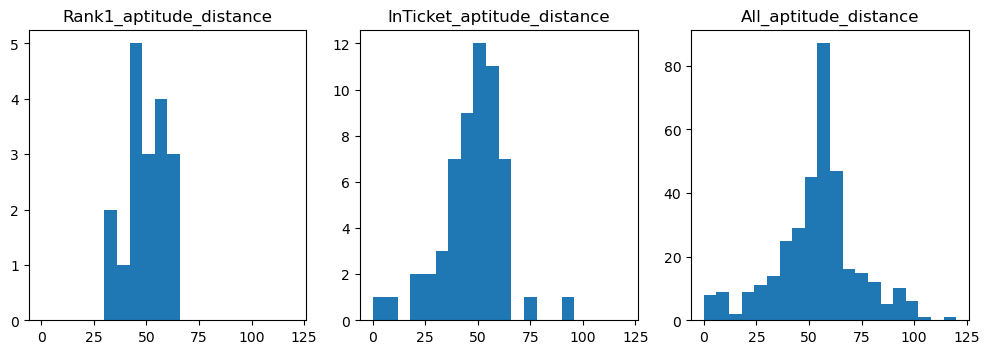

In [29]:
plot_count_columns("aptitude_distance", _range = (0, 120))

過去20年で1着及び馬券内だった馬の脚質適性(高いほど逃げ)

Rank1：サンプル数18
InTicket：サンプル数57
All：サンプル数352


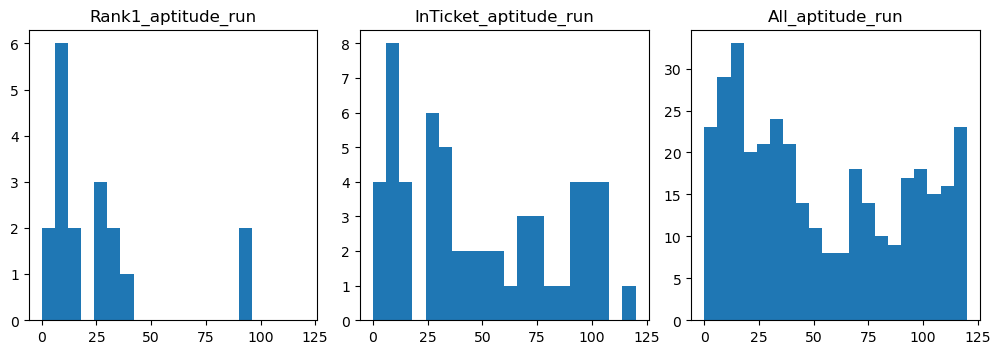

In [30]:
plot_count_columns("aptitude_run", _range = (0, 120))

過去20年で1着及び馬券内だった馬の成長適性(高いほど早熟)

Rank1：サンプル数18
InTicket：サンプル数57
All：サンプル数352


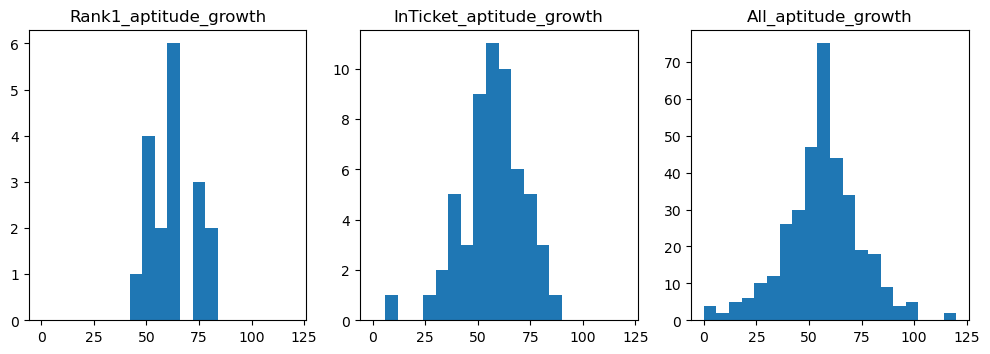

In [31]:
plot_count_columns("aptitude_growth", _range = (0, 120))

過去20年で1着及び馬券内だった馬の馬場適性(高いほど重馬場得意)

Rank1：サンプル数18
InTicket：サンプル数57
All：サンプル数352


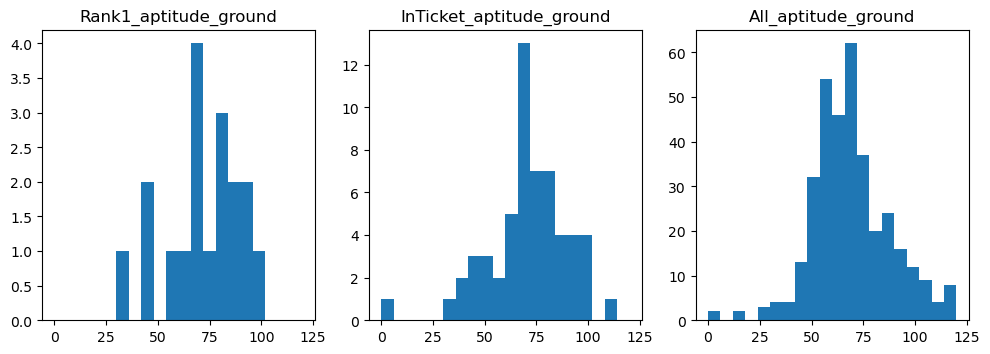

In [32]:
plot_count_columns("aptitude_ground", _range = (0, 120))

過去20年で1着及び馬券内だった馬の過去レース順位平均値

Rank1：サンプル数18
InTicket：サンプル数57
All：サンプル数352


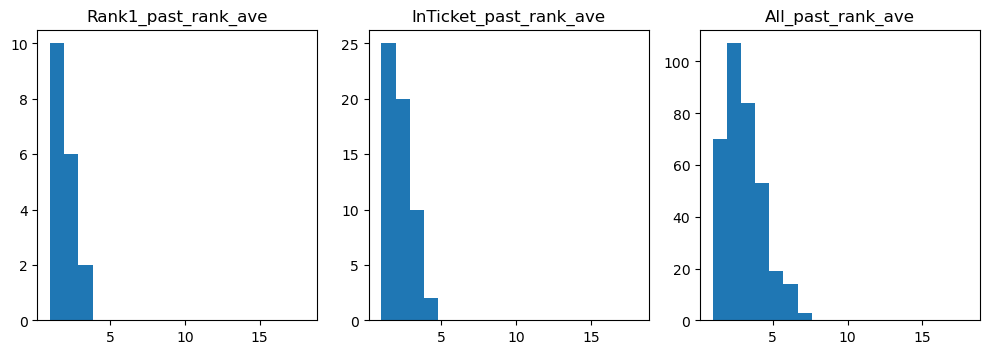

In [33]:
plot_count_columns("past_rank_ave", 18,_range = (1, 18))

過去20年で1着及び馬券内だった馬の前走着順

Rank1：サンプル数18
InTicket：サンプル数57
All：サンプル数352


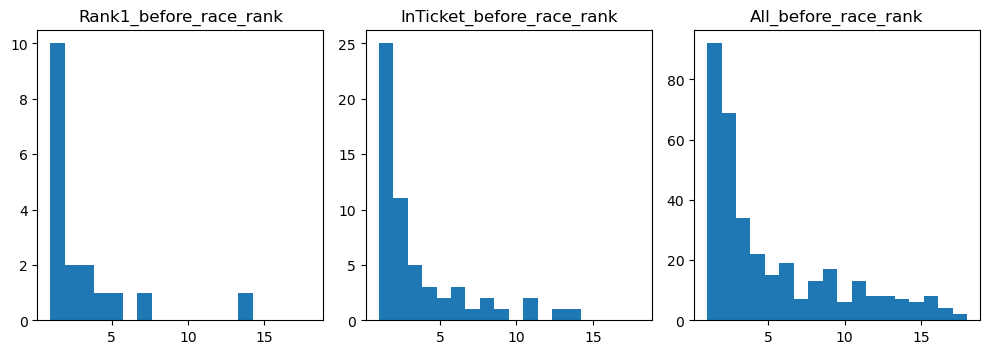

In [34]:
plot_count_columns("before_race_rank", 18,_range = (1, 18))

過去レースの順位データに(G1)などのレースの格を数値化して計算した平均を算出

Rank1：サンプル数18
InTicket：サンプル数57
All：サンプル数352


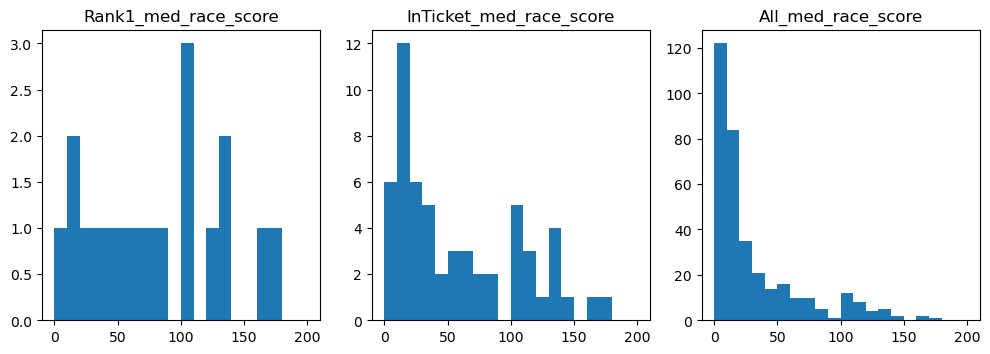

In [35]:
plot_count_columns("med_race_score", _range = (0, 200))

Rank1：サンプル数18
InTicket：サンプル数57
All：サンプル数352


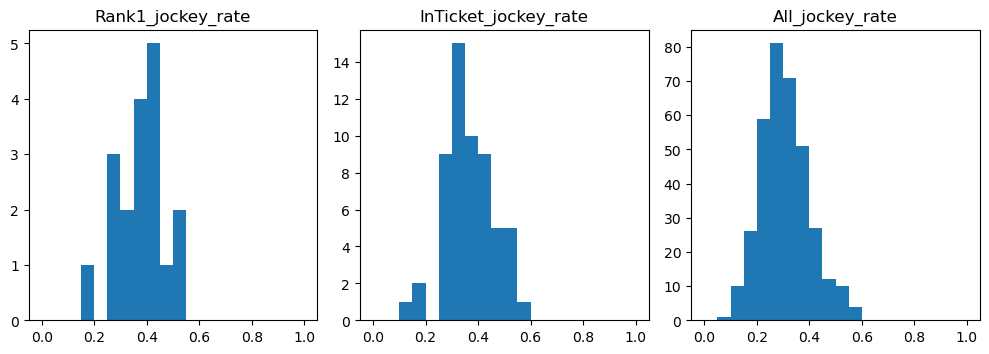

In [36]:
plot_count_columns("jockey_rate", _range = (0, 1))

### 特徴量抽出

In [37]:
df_races_train = []
df_races_test = []
df_races_all = pd.concat(df_races_2)
for i in range(len(df_races_2)):
    tmp = []
    for j in range(len(df_races_2)):
        if (i == j):
            df_races_test.append(df_races_2[j])
        else:
            tmp.append(df_races_2[j])
    df_races_train.append(pd.concat(tmp))

In [38]:
df_races_train_2 = df_races_train.copy()
df_races_test_2 = df_races_test.copy()
df_races_all_2 = df_races_all.copy()
y_trains = []
(df_races_all_2, y_all) = func.create_param(df_races_all_2)
for i in range(len(df_races_train_2)):
    (df_races_train_2[i], df_races_test_2[i], tmp) = func.create_params(df_races_train_2[i], df_races_test_2[i])
    y_trains.append(tmp)

### 本予想の前に去年のレースを予測してみて正答率を確認する

In [39]:
TEST_NUM = 20 # 予想対象レース

In [40]:
df_races_test_2[0].head(1)

,frame_number,aptitude_course,aptitude_distance,aptitude_run,aptitude_growth,aptitude_ground,weight,race_count,jockey_rate,past_rank_ave,before_race_rank,past_rank_std,med_race_score
1,6,107,45,29,44,60,57,8,0.398,1.833333,1,0.983192,15.47619


In [41]:
y_train = y_trains[TEST_NUM]

In [42]:
X_train = df_races_train_2[TEST_NUM].values.astype(np.float)
X_train.shape

C:\Users\mano2\AppData\Local\Temp\ipykernel_28628\2626878118.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_train = df_races_train_2[TEST_NUM].values.astype(np.float)


(336, 13)

In [43]:
X_test = df_races_test_2[TEST_NUM].values.astype(np.float)
X_test.shape

C:\Users\mano2\AppData\Local\Temp\ipykernel_28628\32131183.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_test = df_races_test_2[TEST_NUM].values.astype(np.float)


(16, 13)

In [44]:
mm = preprocessing.MinMaxScaler()
X_train = mm.fit_transform(X_train)
X_test = mm.fit_transform(X_test)

### 機械学習開始

In [45]:
# 機械学習のモデルを読み込む
from sklearn import tree
from sklearn import svm
from sklearn import ensemble
from sklearn import neighbors
from sklearn import linear_model

# 機械学習のお役立ちモジュールを読み込む
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics

In [46]:
def stratified_cv(X, y, clf_class, shuffle=True, n_folds=10, **kwargs):
    stratified_k_fold = StratifiedKFold(n_splits = n_folds, shuffle = shuffle).split(X, y)
    y_pred = y.copy()
    for ii, jj in stratified_k_fold:
        X_train, X_test = X[ii], X[jj]
        y_train = y[ii]
        clf = clf_class(**kwargs)
        clf.fit(X_train, y_train)
        y_pred[jj] = clf.predict(X_test)
    return y_pred

5つの学習モデルで正答率比較　(Dump Classifierはすべての入力に0を返すモデル)

In [47]:
print('Passive Aggressive Classifier: {:.3f}'.format(metrics.accuracy_score(y_train, stratified_cv(X_train, y_train, linear_model.PassiveAggressiveClassifier))))
print('Gradient Boosting Classifier:  {:.3f}'.format(metrics.accuracy_score(y_train, stratified_cv(X_train, y_train, ensemble.GradientBoostingClassifier))))
print('Support vector machine(SVM):   {:.3f}'.format(metrics.accuracy_score(y_train, stratified_cv(X_train, y_train, svm.SVC))))
print('Random Forest Classifier:      {:.3f}'.format(metrics.accuracy_score(y_train, stratified_cv(X_train, y_train, ensemble.RandomForestClassifier))))
print('K Nearest Neighbor Classifier: {:.3f}'.format(metrics.accuracy_score(y_train, stratified_cv(X_train, y_train, neighbors.KNeighborsClassifier))))
print('Dump Classifier: {:.3f}'.format(metrics.accuracy_score(y_train, [0 for ii in y_train.tolist()])))

Passive Aggressive Classifier: 0.720
Gradient Boosting Classifier:  0.824
Support vector machine(SVM):   0.839
Random Forest Classifier:      0.830
K Nearest Neighbor Classifier: 0.827
Dump Classifier: 0.839


### 正答率の高かったモデルが予測時に何を重要視したかを出力

In [48]:
# linear_model.PassiveAggressiveClassifier()
# ensemble.GradientBoostingClassifier()
# svm.SVC()
# ensemble.RandomForestClassifier()
# neighbors.KNeighborsClassifier()

model = ensemble.RandomForestClassifier()
model.fit(X_train, y_train)

RandomForestClassifier()

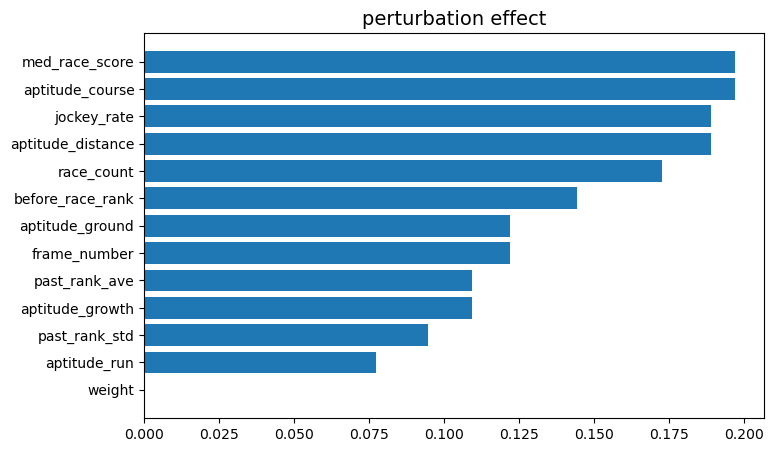

aptitude_distance, perturbation effect: 12.69%
aptitude_course, perturbation effect: 10.66%
jockey_rate, perturbation effect: 9.73%
med_race_score, perturbation effect: 9.73%
jockey_rate, perturbation effect: 8.71%
med_race_score, perturbation effect: 8.14%
race_count, perturbation effect: 7.54%
aptitude_ground, perturbation effect: 7.54%
before_race_rank, perturbation effect: 6.88%
past_rank_std, perturbation effect: 6.88%
before_race_rank, perturbation effect: 6.16%
past_rank_std, perturbation effect: 5.33%
aptitude_growth, perturbation effect: 0.00%


In [49]:
func.plot_importance(func.calc_importance(model, X_train), df_races_test_2[0].columns.values)
func.print_importance(func.calc_importance(model, X_train), df_races_test_2[0].columns.values)

予測結果出力

In [50]:
y_pred = model.predict(X_test)
print(y_pred)
for i in range(len(y_pred)):
    if (y_pred[i]):
        print(df_races_2[TEST_NUM].iloc[[i]]['horse_name'])

[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
1    イクイノックス
Name: horse_name, dtype: object


### 今年のレースを予測

In [51]:
PRED_RACE_COLUMNS = [
    "frame_number",
    "horse_number",
    "mark",
    "horse_name",
    "url",
    "aptitude_course",
    "aptitude_distance",
    "aptitude_run",
    "aptitude_growth",
    "aptitude_ground",
    "age",
    "weight",
    "jockey",
    "jockey_id",
    "trainer",
    "blank_1",
    "blank_2",
    "blank_3",
    "blank_4",
    "blank_5"
]

In [52]:
df_pred_race = pd.read_csv(CSV_DIR+ RACE + str(int(TRAIN_RACE_ID[0][:4]) + 1) + RACE_NAME + ".csv", header=None, names = PRED_RACE_COLUMNS, encoding='shift_jis')

In [53]:
num = RACE_CNT
df_pred_race.head(5)

,frame_number,horse_number,mark,horse_name,url,aptitude_course,aptitude_distance,aptitude_run,aptitude_growth,aptitude_ground,age,weight,jockey,jockey_id,trainer,blank_1,blank_2,blank_3,blank_4,blank_5
0,1,1,--◎◯▲△☆&#10003消,ベラジオオペラ,https://db.netkeiba.com/horse/2020102781,116,116,58,58,58,牡3,57.0,横山和,1140,栗東上村,NaN,---.-,**,NaN,NaN
1,1,2,--◎◯▲△☆&#10003消,スキルヴィング,https://db.netkeiba.com/horse/2020103722,116,19,1,58,58,牡3,57.0,ルメール,5339,美浦木村,NaN,---.-,**,NaN,NaN
2,2,3,--◎◯▲△☆&#10003消,ホウオウビスケッツ,https://db.netkeiba.com/horse/2020103941,116,58,1,58,1,牡3,57.0,丸田,1117,美浦奥村武,NaN,---.-,**,NaN,NaN
3,2,4,--◎◯▲△☆&#10003消,トップナイフ,https://db.netkeiba.com/horse/2020106402,87,96,116,96,58,牡3,57.0,横山典,660,栗東昆,NaN,---.-,**,NaN,NaN
4,3,5,--◎◯▲△☆&#10003消,ソールオリエンス,https://db.netkeiba.com/horse/2020102899,116,41,18,19,98,牡3,57.0,横山武,1170,美浦手塚,NaN,---.-,**,NaN,NaN


In [54]:
df_pred_race_2 = df_pred_race.copy()
drop_columns = ['trainer', 'owner', 'jockey', 'mark', 'url', 'blank_1', 'blank_2', 'blank_3', 'blank_4', 'blank_5']
df_pred_race_2.fillna({'time_score': '**'})
df_pred_race_2.dropna(how='all', axis = 1, inplace=True)
df_pred_race_2 = df_pred_race_2.drop(columns = drop_columns, errors = 'ignore')
df_pred_race_2['horse_data_key'] = df_pred_race_2.apply(load_horse_data, num = num, axis = 1)
df_pred_race_2['race_count'] = df_pred_race_2.apply(lambda x: int(db_horses[x['horse_data_key']].shape[0]), axis = 1)
df_pred_race_2['jockey_rate'] = df_pred_race_2.apply(add_jockey_info, axis = 1)
df_pred_race_2 = feature_creation(df_pred_race_2, -1)

In [55]:
df_pred_race_2.head(5)

,frame_number,horse_number,horse_name,aptitude_course,aptitude_distance,aptitude_run,aptitude_growth,aptitude_ground,age,weight,jockey_id,horse_data_key,race_count,jockey_rate,past_rank_ave,before_race_rank,past_rank_std,med_race_score
0,1,1,ベラジオオペラ,116,116,58,58,58,牡3,57.0,1140,2023ベラジオオペラ,4,0.299,3.250000,1,4.500000,27.083333
1,1,2,スキルヴィング,116,19,1,58,58,牡3,57.0,5339,2023スキルヴィング,4,0.515,1.250000,2,0.500000,20.357143
2,2,3,ホウオウビスケッツ,116,58,1,58,1,牡3,57.0,1117,2023ホウオウビスケッツ,4,0.118,5.250000,1,7.847505,20.000000
3,2,4,トップナイフ,87,96,116,96,58,牡3,57.0,660,2023トップナイフ,9,0.331,3.111111,6,2.147350,18.750000
4,3,5,ソールオリエンス,116,41,18,19,98,牡3,57.0,1170,2023ソールオリエンス,3,0.356,1.000000,1,0.000000,166.666667


In [56]:
df_pred_race_3 = df_pred_race_2.copy()
df_pred_race_3 = df_pred_race_3.drop(columns = ["horse_name", "age", "horse_data_key", "horse_number", "jockey_id"])
df_pred_race_3.head(1)

,frame_number,aptitude_course,aptitude_distance,aptitude_run,aptitude_growth,aptitude_ground,weight,race_count,jockey_rate,past_rank_ave,before_race_rank,past_rank_std,med_race_score
0,1,116,116,58,58,58,57.0,4,0.299,3.25,1,4.5,27.083333


In [57]:
df_pred_race_3.shape
x_pred = df_pred_race_3.values.astype(np.float)

C:\Users\mano2\AppData\Local\Temp\ipykernel_28628\2027925873.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x_pred = df_pred_race_3.values.astype(np.float)


In [58]:
X_all = df_races_all_2.values.astype(np.float)

C:\Users\mano2\AppData\Local\Temp\ipykernel_28628\3859458393.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_all = df_races_all_2.values.astype(np.float)


In [59]:
X_all = mm.fit_transform(X_all)
x_pred = mm.fit_transform(x_pred)

In [60]:
horse_names = df_pred_race_2['horse_name']
models = []
models.append(linear_model.PassiveAggressiveClassifier())
models.append(ensemble.GradientBoostingClassifier())
models.append(svm.SVC())
models.append(ensemble.RandomForestClassifier())
models.append(neighbors.KNeighborsClassifier())
names = []
preds = np.zeros(len(horse_names), dtype=np.int64)
for _ in range(100):
    for i in range(len(models)):
        models[i].fit(X_all, y_all)
        y_pred = models[i].predict(x_pred)
        preds = preds + y_pred
        for j in range(len(y_pred)):
            if (y_pred[j]):
                names.append(horse_names[j])
print(preds.tolist())
print(collections.Counter(names))

[7, 90, 0, 0, 294, 3, 1, 0, 0, 1, 18, 224, 0, 101, 8, 1, 1, 11]
Counter({'ソールオリエンス': 294, 'タスティエーラ': 224, 'ファントムシーフ': 101, 'スキルヴィング': 90, 'ハーツコンチェルト': 18, 'サトノグランツ': 11, 'ノッキングポイント': 8, 'ベラジオオペラ': 7, 'ショウナンバシット': 3, 'フリームファクシ': 1, 'シャザーン': 1, 'パクスオトマニカ': 1, 'ドゥラエレーデ': 1})
